Attempting to read '/content/UCI_Credit_Card.csv.xlsx' as CSV...
Failed to read as CSV: 'utf-8' codec can't decode bytes in position 15-16: invalid continuation byte
Attempting to read '/content/UCI_Credit_Card.csv.xlsx' as Excel...
Successfully read as Excel.

Shape of the DataFrame: (30000, 25)

First 5 rows:
   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...          0          0          0         0       689         0   
1  ...       3272       3455       3261         0      1000      1

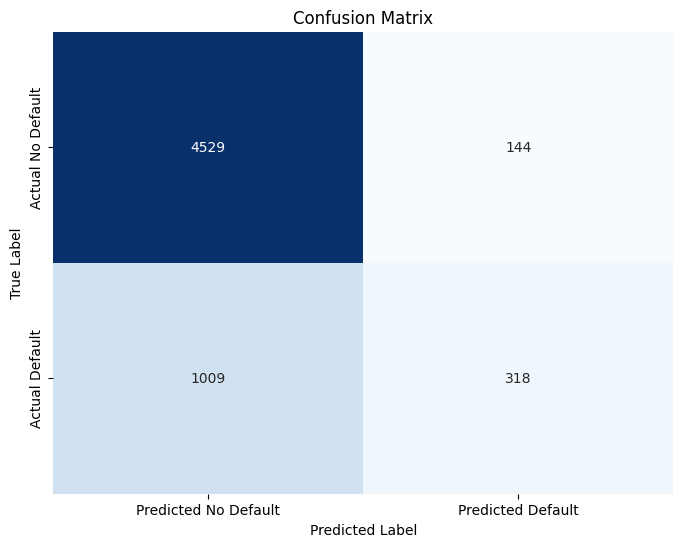


ROC AUC Score: 0.7076

--- Prediction on New Data (Example) ---

Sample New Data (First 5 rows of test features):
       LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
6907       50000    1          2         2   46     -1     -1     -1     -1   
24575     150000    1          1         1   31     -1     -1     -2     -2   
26766      50000    1          2         2   25      0      0      0      0   
2156      290000    2          1         2   25      0      0      0      0   
3179      500000    2          2         1   27     -2     -2     -2     -2   

       PAY_5  ...  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  \
6907       0  ...          0       2650       3320       2764     26060   
24575     -2  ...          0          0          0      11694         0   
26766      0  ...      49009      49949      50479      50702      1800   
2156       0  ...     296384     248801     241983     230925     15000   
3179      -2  ...      13570      1

In [1]:
# --- Install required libraries ---
# Ensure these are installed
!pip install pandas scikit-learn matplotlib seaborn openpyxl --quiet

# --- IMPORTS ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression # Using Logistic Regression for classification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# --- LOAD DATA ---
file_path = "/content/UCI_Credit_Card.csv.xlsx"
df = None

try:
    # Attempt to read as CSV first, as suggested by previous analysis
    print(f"Attempting to read '{file_path}' as CSV...")
    df = pd.read_csv(file_path)
    print("Successfully read as CSV.")
except Exception as csv_e:
    print(f"Failed to read as CSV: {csv_e}")
    print(f"Attempting to read '{file_path}' as Excel...")
    try:
        # If CSV read fails, try reading as Excel
        df = pd.read_excel(file_path, header=0, engine='openpyxl')
        print("Successfully read as Excel.")
    except Exception as excel_e:
        print(f"Failed to read as Excel: {excel_e}")
        print(f"Could not read the file '{file_path}'. Please check the file path and format.")
        # Re-raise the exception if both attempts fail
        raise excel_e

# Display initial info about the loaded data
if df is not None:
    print(f"\nShape of the DataFrame: {df.shape}")
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nColumn names before renaming:")
    print(df.columns.tolist())

    # --- DATA PREPARATION (Based on UCI_Credit_Card dataset) ---
    # Rename the target column
    # The actual column name in the dataset is often 'default.payment.next.month' or similar.
    # Let's list columns and try common variations or infer from the file.
    # Assuming 'default.payment.next.month' is the column name in the raw file.
    target_col_raw = 'default.payment.next.month' # Common column name for this dataset
    target_col_clean = 'Default'

    # Try renaming the column
    if target_col_raw in df.columns:
        df.rename(columns={target_col_raw: target_col_clean}, inplace=True)
        print(f"\nRenamed column '{target_col_raw}' to '{target_col_clean}'.")
    elif target_col_clean in df.columns:
         print(f"\nColumn '{target_col_clean}' already exists.")
    else:
        print(f"\nWarning: Could not find target column '{target_col_raw}' or '{target_col_clean}'. Available columns: {df.columns.tolist()}")
        # Try to find a column name that looks like the target variable based on common names
        possible_target_cols = [col for col in df.columns if 'default' in col.lower() or 'payment' in col.lower() and 'next' in col.lower()]
        if possible_target_cols:
            print(f"Possible target columns found: {possible_target_cols}. Please verify the correct one.")
            # If you can identify the correct one from here, manually rename it:
            # correct_col = possible_target_cols[0] # Replace with the correct column name if needed
            # df.rename(columns={correct_col: target_col_clean}, inplace=True)
            # print(f"Attempted rename of '{correct_col}' to '{target_col_clean}'.")
        raise KeyError(f"Target column '{target_col_raw}' or '{target_col_clean}' not found after attempts.")


    # Drop the 'ID' column as it's usually not useful for prediction
    if 'ID' in df.columns:
        df.drop(columns=["ID"], inplace=True)
        print("\nDropped 'ID' column.")
    else:
        print("\n'ID' column not found. Skipping drop.")

    # Check for missing values
    print("\nMissing values per column:")
    print(df.isnull().sum())

    # Identify categorical and numerical features before handling missing values
    # This needs to happen BEFORE trying to loop through numerical_features and categorical_features
    categorical_features = df.select_dtypes(include=['object', 'category']).columns
    numerical_features = df.select_dtypes(include=np.number).columns


    # Handle potential missing values (if any are found above)
    # For simplicity, we'll fill numerical missing values with the mean
    # and categorical with the most frequent value. Adjust based on your data.
    for col in numerical_features:
         if df[col].isnull().any():
             mean_val = df[col].mean()
             df[col].fillna(mean_val, inplace=True)
             print(f"Filled missing values in '{col}' with mean ({mean_val:.2f}).")

    for col in categorical_features:
         if df[col].isnull().any():
             mode_val = df[col].mode()[0]
             df[col].fillna(mode_val, inplace=True)
             print(f"Filled missing values in '{col}' with mode ('{mode_val}').")

    print("\nMissing values after handling:")
    print(df.isnull().sum())


    # Define features (X) and target (y) after cleaning and dropping columns
    # Re-identify features in case the filling process changed dtypes or created new columns (unlikely here, but good practice)
    # In this specific case, the column definitions before and after filling should be the same,
    # but defining X and y uses the *cleaned* df.
    X = df.drop(target_col_clean, axis=1)
    y = df[target_col_clean]

    # Re-identify categorical and numerical features based on the processed X
    # This is necessary because X excludes the target column.
    categorical_features = X.select_dtypes(include=['object', 'category']).columns
    numerical_features = X.select_dtypes(include=np.number).columns


    print(f"\nCategorical features for preprocessing: {list(categorical_features)}")
    print(f"Numerical features for preprocessing: {list(numerical_features)}")


    # Create preprocessing pipelines for numerical and categorical features
    # Numerical features will be scaled using StandardScaler
    # Categorical features will be one-hot encoded
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ],
        remainder='passthrough' # Keep other columns (if any) - adjust if needed
    )

    # --- SPLIT DATA ---
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Stratify for balanced classes

    print(f"\nTraining data shape: {X_train.shape}")
    print(f"Testing data shape: {X_test.shape}")

    # --- BUILD AND TRAIN MODEL ---
    # Create a pipeline that first preprocesses the data and then applies the model
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('classifier', LogisticRegression(solver='liblinear', random_state=42))]) # Using liblinear for binary

    # Train the model using the training data
    print("\nTraining the model...")
    model_pipeline.fit(X_train, y_train)
    print("Model training complete.")

    # --- EVALUATION ---
    # Make predictions on the test set
    y_pred = model_pipeline.predict(X_test)
    y_prob = model_pipeline.predict_proba(X_test)[:, 1] # Get probabilities for the positive class

    print("\n--- Model Evaluation ---")

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Classification Report (includes precision, recall, f1-score)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted No Default', 'Predicted Default'],
                yticklabels=['Actual No Default', 'Actual Default'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


    # ROC AUC Score
    # Ensure target variable is binary (0 or 1) for ROC AUC
    if len(np.unique(y_test)) == 2:
        roc_auc = roc_auc_score(y_test, y_prob)
        print(f"\nROC AUC Score: {roc_auc:.4f}")
    else:
        print("\nROC AUC Score skipped: Target variable is not binary in the test set.")

    # --- DEMONSTRATE PREDICTION ON NEW DATA (example) ---
    print("\n--- Prediction on New Data (Example) ---")

    # Create a sample of new data (ensure it has the same column names as the training data BEFORE preprocessing)
    # Use the first 5 rows of the *original* test set features as an example of new data
    sample_new_data = X_test.head(5)

    # Predict on the new data using the pipeline
    new_predictions = model_pipeline.predict(sample_new_data)
    new_probabilities = model_pipeline.predict_proba(sample_new_data)[:, 1]

    print("\nSample New Data (First 5 rows of test features):")
    print(sample_new_data)
    print("\nPredictions for new data:")
    print(new_predictions)
    print("\nProbabilities for new data (Probability of Default=1):")
    print(new_probabilities)

else:
    print("\nDataFrame 'df' was not loaded successfully. Cannot proceed with analysis.")